In [231]:
import csp
from csp import ts
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

# Task1: Golden Cross Start.

In [235]:
class Quote(csp.Struct):
    bid: float
    ask: float
    bid_qty: int
    ask_qty: int

class Order(csp.Struct):
    position: str
    price: float
    qty: int
    type: str
    
class Trade(csp.Struct):
    position: str
    price: float
    qty: int
    latency: float
    
# class ExecReport(csp.Struct):
#     order_id: int
#     order_type: str
#     status: str
#     position: int
#     qty: int
#     latency: float

In [236]:
@csp.node
def my_market_simulator(mu: float = 0, sigma: float = 0.2, sigma_spread: float = 0.1, model: str = "GBM") -> ts[Quote]:
    
    with csp.alarms():
        alarm = csp.alarm(bool)
        
    with csp.state():
        s_bid = 100.01
        s_ask = 99.99
        s_mid = (s_bid + s_ask) / 2
        s_bid_qty = 10
        s_ask_qty = 10
        mu_second = mu / (252 * 24 * 60 * 60)
        sigma_second = sigma / np.sqrt(252 * 24 * 60 * 60)
        sigma_spread_second = sigma_spread / np.sqrt(252 * 24 * 60 * 60)
        dt  = 1 # 1 second
        
    with csp.start():
        csp.schedule_alarm(alarm, timedelta(seconds=1), True)
        
    if csp.ticked(alarm):
        csp.schedule_alarm(alarm, timedelta(seconds=1), True)
        
        if model == "GBM":
            # [add] get current time and use heterogeneous sigma
            s_mid *= np.exp((mu_second - 0.5 * sigma_second ** 2) * dt + sigma_second * np.sqrt(dt) * np.random.randn())
            spread = min(abs(3 * sigma_spread_second * np.random.randn() * s_mid), 3 * sigma_spread_second * s_mid)
            s_bid = s_mid + 0.5 * spread
            s_ask = s_mid - 0.5 * spread
            s_bid_qty = np.random.randint(1, 100)
            s_ask_qty = np.random.randint(1, 100)
            market = Quote(bid = s_bid, ask = s_ask, bid_qty = s_bid_qty, ask_qty = s_ask_qty)
            return market
        
@csp.node
def my_weighted_mid(market: ts[Quote]) -> ts[float]:
    w_bid = market.bid_qty / (market.bid_qty + market.ask_qty)
    w_ask = market.ask_qty / (market.bid_qty + market.ask_qty)
    return w_bid * market.bid + w_ask * market.ask

@csp.node
def my_moving_average(window_size: int, mid_prices: ts[float]) -> ts[float]:
    with csp.start():
        assert window_size > 0
        csp.set_buffering_policy(mid_prices, tick_history=timedelta(seconds=window_size))
    if csp.ticked(mid_prices):
        buffer = csp.values_at(mid_prices, 
                               timedelta(seconds = -window_size),
                               timedelta(seconds = 0),
                               csp.TimeIndexPolicy.INCLUSIVE,
                               csp.TimeIndexPolicy.INCLUSIVE)
        return np.mean(buffer)

@csp.node
def golden_cross(market: ts[Quote], ma5: ts[float], ma10: ts[float]) -> ts[Order]:
    with csp.state():
        s_position_opened = False
        s_sell_trigerred = False
        s_remainings = 0
    if csp.ticked(market, ma5, ma10) and csp.valid(market, ma5, ma10):
        if ma5 > ma10 and not s_position_opened:
            s_position_opened = True
            s_remainings += market.bid_qty
            return Order(position = "BUY", price = market.bid, qty = market.bid_qty, type = "market")
        if ma5 < ma10 and s_position_opened:
            s_position_opened = False
            s_sell_trigerred = True
            selling_qty = min(s_remainings, market.ask_qty)
            s_remainings -= selling_qty
            return Order(position = "SELL", price = market.ask, qty = selling_qty, type = "market")
        
    if csp.ticked(market) and s_sell_trigerred:
        if s_remainings == 0:
            s_sell_trigerred = False
        if s_remainings > 0:
            selling_qty = min(s_remainings, market.ask_qty)
            s_remainings -= selling_qty
            return Order(position = "SELL", price = market.ask, qty = selling_qty, type = "market")
            
@csp.node
def gateway(orders: ts[Order]) -> ts[Trade]:
    if csp.ticked(orders):
        return Trade(position = orders.position, price = orders.price, qty = orders.qty, latency = 0.01)
    
@csp.node
def calc_pnl(mid: ts[float], trades: ts[Trade]) -> ts[float]:
    with csp.state():
        s_position_qty = 0
        s_pnl = 0
        s_buying_price = 0
        
    if csp.ticked(trades):
        if trades.position == "BUY":
            s_position_qty += trades.qty
            s_buying_price = trades.price
        else:
            s_position_qty -= trades.qty
        
    if csp.ticked(mid):
        s_pnl += (mid - s_buying_price) * s_position_qty
        return s_pnl

In [237]:
@csp.graph
def my_graph():
    market = my_market_simulator()
    mid = my_weighted_mid(market)
    ma5 = my_moving_average(window_size=5, mid_prices=mid)
    ma10 = my_moving_average(window_size=10, mid_prices=mid)
    signals = golden_cross(market, ma5, ma10)
    trades = gateway(signals)
    pnl = calc_pnl(mid, trades)
    # csp.print("market", market)
    # # csp.print("mid", mid)
    # csp.print("ma5", ma5)
    # csp.print("ma10", ma10)
    # csp.print("signals", signals)
    # csp.print("trades", trades)
    
    csp.add_graph_output("market", market)
    csp.add_graph_output("ma5", ma5)
    csp.add_graph_output("ma10", ma10)
    csp.add_graph_output("signals", signals)
    csp.add_graph_output("pnl", pnl)

In [247]:
def main():
    np.random.seed(0)
    start = datetime(2025, 1, 1, 9, 30, 0)
    end = datetime(2025, 1, 1, 9, 35, 0)
    results = csp.run(my_graph, starttime=start, endtime=end, realtime=False)
    
    df = pd.DataFrame()
    for i in range(len(results['market'])):
        idx = results['market'][i][0]
        quotes = results['market'][i][1]
        ma5 = results['ma5'][i][1]
        ma10 = results['ma10'][i][1]
        pnl = results['pnl'][i][1]
        df.loc[idx, 'bid'] = quotes.bid
        df.loc[idx, 'ask'] = quotes.ask
        df.loc[idx, 'ma5'] = ma5
        df.loc[idx, 'ma10'] = ma10
        df.loc[idx, 'pnl'] = pnl
        
    for i in range(len(results['signals'])):
        idx = results['signals'][i][0]
        order = results['signals'][i][1]
        df.loc[idx, 'signals'] = order.position
    

    # Plot 1: bid/ask
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df['bid'], label='Bid')
    plt.plot(df.index, df['ask'], label='Ask')
    plt.title('Bid and Ask Prices')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Moving averages + triangle signals
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df['ma5'], label='MA5')
    plt.plot(df.index, df['ma10'], label='MA10')

    # Plot triangle markers for signals
    buy_signals = df[df['signals'] == 'BUY']
    sell_signals = df[df['signals'] == 'SELL']
    plt.scatter(buy_signals.index, df.loc[buy_signals.index, 'ma5'], marker='^', color='green', label='BUY', s=100)
    plt.scatter(sell_signals.index, df.loc[sell_signals.index, 'ma10'], marker='v', color='red', label='SELL', s=100)

    plt.title('Golden Cross Strategy with BUY/SELL Signals')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

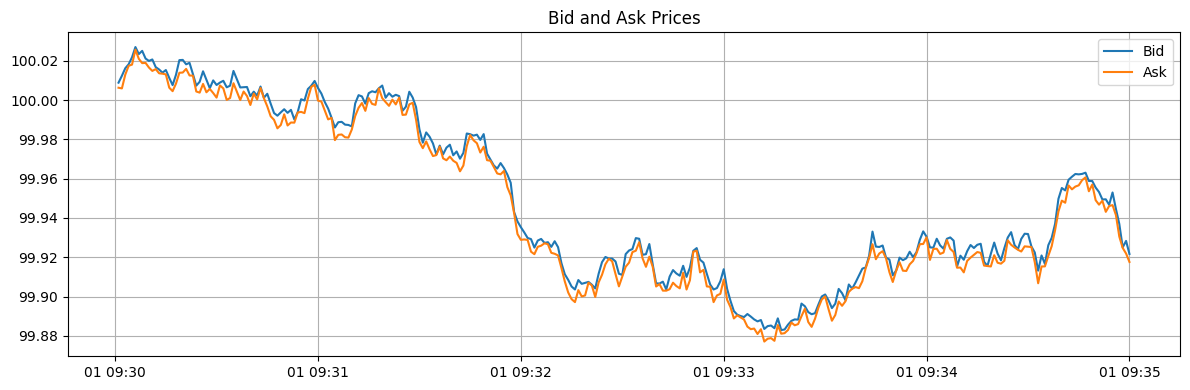

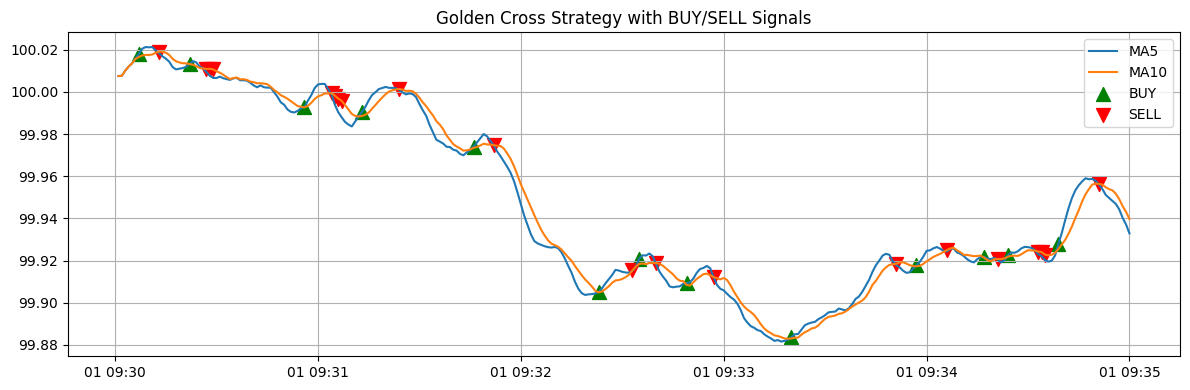

In [248]:
main()

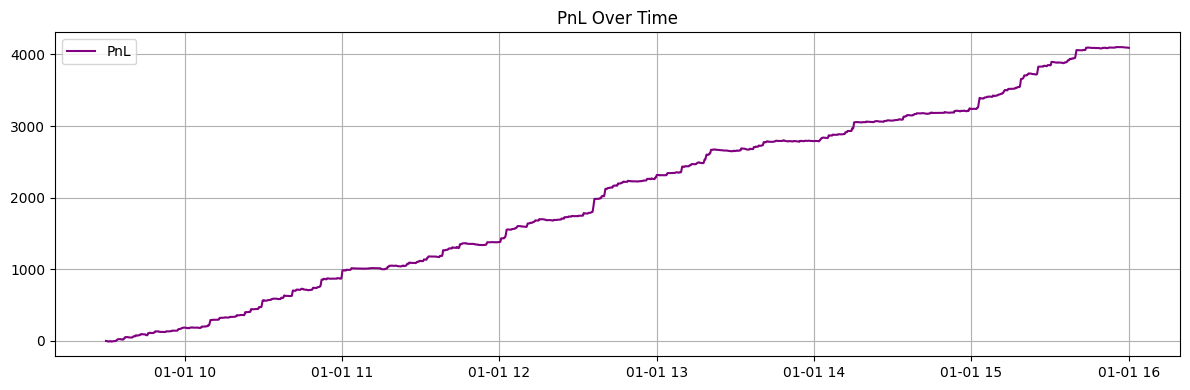

In [249]:
def main():
    np.random.seed(2025)
    start = datetime(2025, 1, 1, 9, 30, 0)
    end = datetime(2025, 1, 1, 16, 00, 0) # market closed
    results = csp.run(my_graph, starttime=start, endtime=end, realtime=False)
    
    df = pd.DataFrame()
    for i in range(len(results['market'])):
        idx = results['market'][i][0]
        quotes = results['market'][i][1]
        ma5 = results['ma5'][i][1]
        ma10 = results['ma10'][i][1]
        pnl = results['pnl'][i][1]
        df.loc[idx, 'bid'] = quotes.bid
        df.loc[idx, 'ask'] = quotes.ask
        df.loc[idx, 'ma5'] = ma5
        df.loc[idx, 'ma10'] = ma10
        df.loc[idx, 'pnl'] = pnl
        
    for i in range(len(results['signals'])):
        idx = results['signals'][i][0]
        order = results['signals'][i][1]
        df.loc[idx, 'signals'] = order.position
    
    # Plot 4: PnL
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df['pnl'], label='PnL', color='purple')
    plt.title('PnL Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
main()